# Loading

In [1]:
import numpy as np
import glob
import nibabel as nib
import os
import random
import h5py
import shutil
from multiprocessing import Pool

In [5]:
def load_micaii(path, num_files_to_load=float('inf'), n_zero_ratio = 0.1): # 
    data_list = data_list = glob.glob(nii_path + '*.nii.gz')[:num_files_to_load]
    data = []
    for file in data_list:
        img = nib.load(file).get_fdata()
        #img = img / np.max(img)
        for vol in range(img.shape[3]):
            for slc in range(img.shape[2]):
                if np.count_nonzero(img[:, :, slc, vol]) / np.prod(img[:, :, slc, vol].shape) >= n_zero_ratio:
                    data.append(img[:, :, slc, vol].reshape(img.shape[0], img.shape[1], 1))            
    return np.array(data)
    

In [6]:
nii_path = '/Users/amanchopra/Documents/School/College/Fall 2021/CS 390ANP/Deep-Learning-MRI-Reconstruction/Data/canine-legs/training-images/'
imgs = load_micaii(nii_path, num_files_to_load=3)

# Undersampling K-Space

Text(0.5, 1.0, 'Mask for Undersampling')

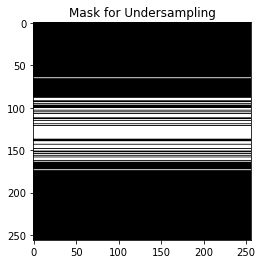

In [61]:
import pickle
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

with open('/Users/amanchopra/Documents/School/College/Fall 2021/CS 390ANP/Deep-Learning-MRI-Reconstruction/Data/mask.pickle', 'rb') as f:
    mask = pickle.load(f)

plt.imshow(mask, cmap='gray')
plt.title('Mask for Undersampling')

In [88]:
def unsample_data(data, mask, accelaration_factor=5):
    uns_data = []
    for i in range(data.shape[0]):
        fourier = np.fft.fft2(data[i,:,:])
        cen_fourier  = np.fft.fftshift(fourier)
        subsam_fourier = np.multiply(cen_fourier,mask) # undersampling in k-space
        uncen_fourier = np.fft.ifftshift(subsam_fourier)
        zro_image = np.fft.ifft2(uncen_fourier) # zero-filled reconstruction
        uns_data.append(zro_image)        
    return np.array(uns_data)

def unsample_data_add_noise(data, mask, noise_ratio, accelaration_factor=5):
    fft_data = []
    uns_data = []
    for i in range(data.shape[0]):
        fourier = np.fft.fft2(data[i,:,:])
        cen_fourier  = np.fft.fftshift(fourier)
        fft_data.append(cen_fourier)
    fft_data = np.array(fft_data)
    fft_std = np.std(fft_data)
    
    nstd = (noise_ratio*fft_std)/np.sqrt(2)
    insh = (fft_data.shape[1],fft_data.shape[2])
    
    for i in range(fft_data.shape[0]):    
        fft_noise=fft_data[i,:,:]+np.random.normal(0,nstd,insh)+1j*np.random.normal(0,nstd,insh) #adding noise
        subsam_fourier = np.multiply(fft_noise,mask) # undersampling in k-space
        uncen_fourier = np.fft.ifftshift(subsam_fourier)
        zro_image = np.fft.ifft2(uncen_fourier) # zero-filled reconstruction
        uns_data.append(zro_image) 
        
    return np.array(uns_data)

In [101]:
num_imgs_uns = 15
X1, X2 = train_test_split(imgs[:num_imgs_uns, :, :, 0])
X2, X3, X4, X5 = np.array_split(X2, 4)

uns_imgs_1 = unsample_data(X1, mask)
uns_imgs_2 = unsample_data_add_noise(X2, mask, 0.1)  #8100:8400    #10%noise-overlapping
uns_imgs_3 = unsample_data_add_noise(X3, mask, 0.2)  #8400:8700    #20%noise-overlapping
uns_imgs_4 = unsample_data_add_noise(X4, mask, 0.1) #8700:10600   #10%noise-nonoverlapping
uns_imgs_5 = unsample_data_add_noise(X5, mask, 0.2)  #10600:12500  #20%noise-nonoverlapping

uns_imgs_final = np.concatenate([uns_imgs_1, uns_imgs_2, uns_imgs_3, uns_imgs_4, uns_imgs_5])
uns_imgs_final = uns_imgs_final.reshape((uns_imgs_final.shape[0], uns_imgs_final.shape[1], uns_imgs_final.shape[2], 1))
uns_imgs_final.shape

(15, 256, 256, 1)